The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 952 kB/s 
     |████████████████████████████████| 120 kB 25.6 MB/s 
     |████████████████████████████████| 1.6 MB 55.1 MB/s 
     |████████████████████████████████| 82 kB 807 kB/s 


# Multiscale Object Detection
:label:`sec_multiscale-object-detection`


In :numref:`sec_anchor`,
we generated multiple anchor boxes centered on each pixel of an input image. 
Essentially these anchor boxes 
represent samples of
different regions of the image.
However, 
we may end up with too many anchor boxes to compute
if they are generated for *every* pixel.
Think of a $561 \times 728$ input image.
If five anchor boxes 
with varying shapes
are generated for each pixel as their center,
over two million anchor boxes ($561 \times 728 \times 5$) need to be labeled and predicted on the image.

## Multiscale Anchor Boxes
:label:`subsec_multiscale-anchor-boxes`

You may realize that
it is not difficult to reduce anchor boxes on an image.
For instance, we can just 
uniformly sample a small portion of pixels
from the input image
to generate anchor boxes centered on them.
In addition, 
at different scales
we can generate different numbers of anchor boxes
of different sizes.
Intuitively,
smaller objects are more likely
to appear on an image than larger ones.
As an example,
$1 \times 1$, $1 \times 2$, and $2 \times 2$ objects 
can appear on a $2 \times 2$ image
in 4, 2, and 1 possible ways, respectively.
Therefore, when using smaller anchor boxes to detect smaller objects, we can sample more regions,
while for larger objects we can sample fewer regions.

To demonstrate how to generate anchor boxes
at multiple scales, let's read an image.
Its height and width are 561 and 728 pixels, respectively.


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('1.jpg')
h, w = img.shape[:2]
h, w

(472, 800)

Recall that in :numref:`sec_conv_layer`
we call a two-dimensional array output of 
a convolutional layer a feature map.
By defining the feature map shape,
we can determine centers of uniformly sampled anchor boxes  on any image.


The `display_anchors` function is defined below.
[**We generate anchor boxes (`anchors`) on the feature map (`fmap`) with each unit (pixel) as the anchor box center.**]
Since the $(x, y)$-axis coordinate values
in the anchor boxes (`anchors`) have been divided by the width and height of the feature map (`fmap`),
these values are between 0 and 1,
which indicate the relative positions of
anchor boxes in the feature map.

Since centers of the anchor boxes (`anchors`)
are spread over all units on the feature map (`fmap`),
these centers must be *uniformly* distributed
on any input image
in terms of their relative spatial positions.
More concretely,
given the width and height of the feature map `fmap_w` and `fmap_h`, respectively,
the following function will *uniformly* sample
pixels in `fmap_h` rows and `fmap_w` columns
on any input image.
Centered on these uniformly sampled pixels,
anchor boxes of scale `s` (assuming the length of the list `s` is 1) and different aspect ratios (`ratios`)
will be generated.


In [3]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

First, let's [**consider
detection of small objects**].
In order to make it easier to distinguish when displayed, the anchor boxes with different centers here do not overlap:
the anchor box scale is set to 0.15
and the height and width of the feature map are set to 4. We can see
that the centers of the anchor boxes in 4 rows and 4 columns on the image are uniformly distributed.


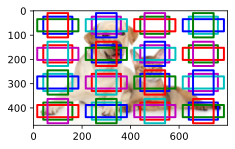

In [4]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

We move on to [**reduce the height and width of the feature map by half and use larger anchor boxes to detect larger objects**]. When the scale is set to 0.4, 
some anchor boxes will overlap with each other.


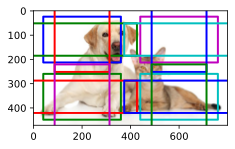

In [5]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

Finally, we [**further reduce the height and width of the feature map by half and increase the anchor box scale to 0.8**]. Now the center of the anchor box is the center of the image.


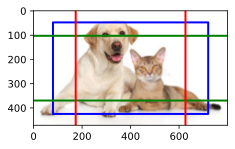

In [6]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## Multiscale Detection


Since we have generated multiscale anchor boxes,
we will use them to detect objects of various sizes
at different scales.
In the following
we introduce a CNN-based multiscale object detection
method that we will implement
in :numref:`sec_ssd`.

At some scale,
say that we have $c$ feature maps of shape $h \times w$.
Using the method in :numref:`subsec_multiscale-anchor-boxes`,
we generate $hw$ sets of anchor boxes,
where each set has $a$ anchor boxes with the same center.
For example, 
at the first scale in the experiments in :numref:`subsec_multiscale-anchor-boxes`,
given ten (number of channels) $4 \times 4$ feature maps,
we generated 16 sets of anchor boxes,
where each set contains 3 anchor boxes with the same center.
Next, each anchor box is labeled with
the class and offset based on ground-truth bounding boxes. At the current scale, the object detection model needs to predict the classes and offsets of $hw$ sets of anchor boxes on the input image, where different sets have different centers.


Assume that the $c$ feature maps here
are the intermediate outputs obtained
by the CNN forward propagation based on the input image. Since there are $hw$ different spatial positions on each feature map,
the same spatial position can be 
thought of as having $c$ units.
According to the
definition of receptive field in :numref:`sec_conv_layer`,
these $c$ units at the same spatial position
of the feature maps
have the same receptive field on the input image:
they represent the input image information
in the same receptive field.
Therefore, we can transform the $c$ units
of the feature maps at the same spatial position
into the
classes and offsets of the $a$ anchor boxes
generated using this spatial position.
In essence,
we use the information of the input image in a certain receptive field
to predict the classes and offsets of the anchor boxes
that are
close to that receptive field
on the input image.


When the feature maps at different layers
have varying-size receptive fields on the input image, they can be used to detect objects of different sizes.
For example, we can design a neural network where
units of feature maps that are closer to the output layer
have wider receptive fields,
so they can detect larger objects from the input image.

In a nutshell, we can leverage
layerwise representations of images at multiple levels
by deep neural networks
for multiscale object detection.
We will show how this works through a concrete example
in :numref:`sec_ssd`.




## Summary

* At multiple scales, we can generate anchor boxes with different sizes to detect objects with different sizes.
* By defining the shape of feature maps, we can determine centers of uniformly sampled anchor boxes on any image.
* We use the information of the input image in a certain receptive field to predict the classes and offsets of the anchor boxes that are close to that receptive field on the input image.
* Through deep learning, we can leverage its layerwise representations of images at multiple levels for multiscale object detection.


## Exercises

1. According to our discussions in :numref:`sec_alexnet`, deep neural networks learn hierarchical features with increasing levels of abstraction for images. In multiscale object detection, do feature maps at different scales correspond to different levels of abstraction? Why or why not?
1. At the first scale (`fmap_w=4, fmap_h=4`) in the experiments in :numref:`subsec_multiscale-anchor-boxes`, generate uniformly distributed anchor boxes that may overlap.
1. Given a feature map variable with shape $1 \times c \times h \times w$, where $c$, $h$, and $w$ are the number of channels, height, and width of the feature maps, respectively. How can you transform this variable into the classes and offsets of anchor boxes? What is the shape of the output?


[Discussions](https://discuss.d2l.ai/t/1607)
